In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import mode
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import json
%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 
#from sleap import load_and_process as lp

In [ ]:
#-------------------------------
# data paths setup
#-------------------------------

#data_dir = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1')
data_dir = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day3')
#data_dir = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day4')
rawdata_paths = [Path(p) for p in data_dir.iterdir() if p.is_dir() and not p.name.endswith('_processedData')]

#-------------------------------
# initial variables setup
#-------------------------------
rawdata_path = rawdata_paths[0]
time_window_start = -2  # s, FOR PLOTTING PURPOSES
time_window_end = 6  # s, FOR PLOTTING PURPOSES
baseline_window = (-5, 0) # s, FOR baselining averages 
event_name = "Apply halt: 2s"  # "Apply halt: 2s"  or "No halt"
vestibular_mismatch = False
common_resampled_rate = 1000 #in Hz
plot_fig1 = True  # whether to plot the first figure with all traces
# for saccades
framerate = 59.77  # Hz (in the future, should come from saved data)
threshold = 65  # px/s FIXME make this adaptive
refractory_period = pd.Timedelta(milliseconds=100)  # msec, using pd.Timedelta for datetime index
plot_saccade_detection_QC = False

data_path = rawdata_path.parent / f"{rawdata_path.name}_processedData/downsampled_data"
save_path = rawdata_path.parent / f"{rawdata_path.name}_processedData"
session_name = "_".join(data_path.parts[-2:])

#-------------------------------
# transient detection variables
#-------------------------------
threshold_percentile = 98 # percentile for thresholding the Ca transient detection, 98
refractory_period = 0.5 # seconds, for the refractory period of the Ca transients, 0.5


In [7]:
#-------------------------------
# load downsampled data 
#-------------------------------
photometry_tracking_encoder_data = pd.read_parquet(data_path / "photometry_tracking_encoder_data.parquet", engine="pyarrow")
camera_photodiode_data = pd.read_parquet(data_path / "camera_photodiode_data.parquet", engine="pyarrow")
experiment_events = pd.read_parquet(data_path / "experiment_events.parquet", engine="pyarrow")
photometry_info = pd.read_parquet(data_path / "photometry_info.parquet", engine="pyarrow")
session_settings = pd.read_parquet(data_path / "session_settings.parquet", engine="pyarrow")
session_settings["metadata"] = session_settings["metadata"].apply(process.safe_from_json)

print(f"✅ Finished loading all parquet files")

# Calculate time differences between event_name events
event_times = experiment_events[experiment_events["Event"] == event_name].index
time_diffs = event_times.to_series().diff().dropna().dt.total_seconds()

# # Print the 5 shortest time differences
# print("5 shortest time differences between events:")
# print(time_diffs.nsmallest(5))

if (time_diffs < 10).any():
    print(f"⚠️ Warning: Some '{event_name}' events are less than 10 seconds apart. Consider applying a filter to events.")

mouse_name = process.check_exp_events(experiment_events, photometry_info, verbose = True)


✅ Finished loading all parquet files
⚠️ Warning: Some 'Apply halt: 2s' events are less than 10 seconds apart. Consider applying a filter to events.
ℹ️ Mousename: B6J2717
ℹ️ Unique events and their counts:
Event
Wait for run threshold...            50
Check halt probability               48
No halt                              26
Halt delay: 0s                       22
Apply halt: 2s                       22
Homing platform                       2
Block timer elapsed                   2
Sync signal started                   1
DrumBase block started                1
DrumWithReverseHalt block started     1
Name: count, dtype: int64
ℹ️ block events
                                                        Event  Time Difference
Time                                                                          
1904-01-06 01:59:13.365056             DrumBase block started              NaN
1904-01-06 02:04:13.471456                Block timer elapsed       300.106400
1904-01-06 02:04:13.471456  Dru

✅ 22 events found. Matching number of photodiode falling edges and 'Apply halt: 2s' events.
time difference between photodiode and experimenet events:
min 84.5 ms. avg 101.2 ms. max 132.2 ms.


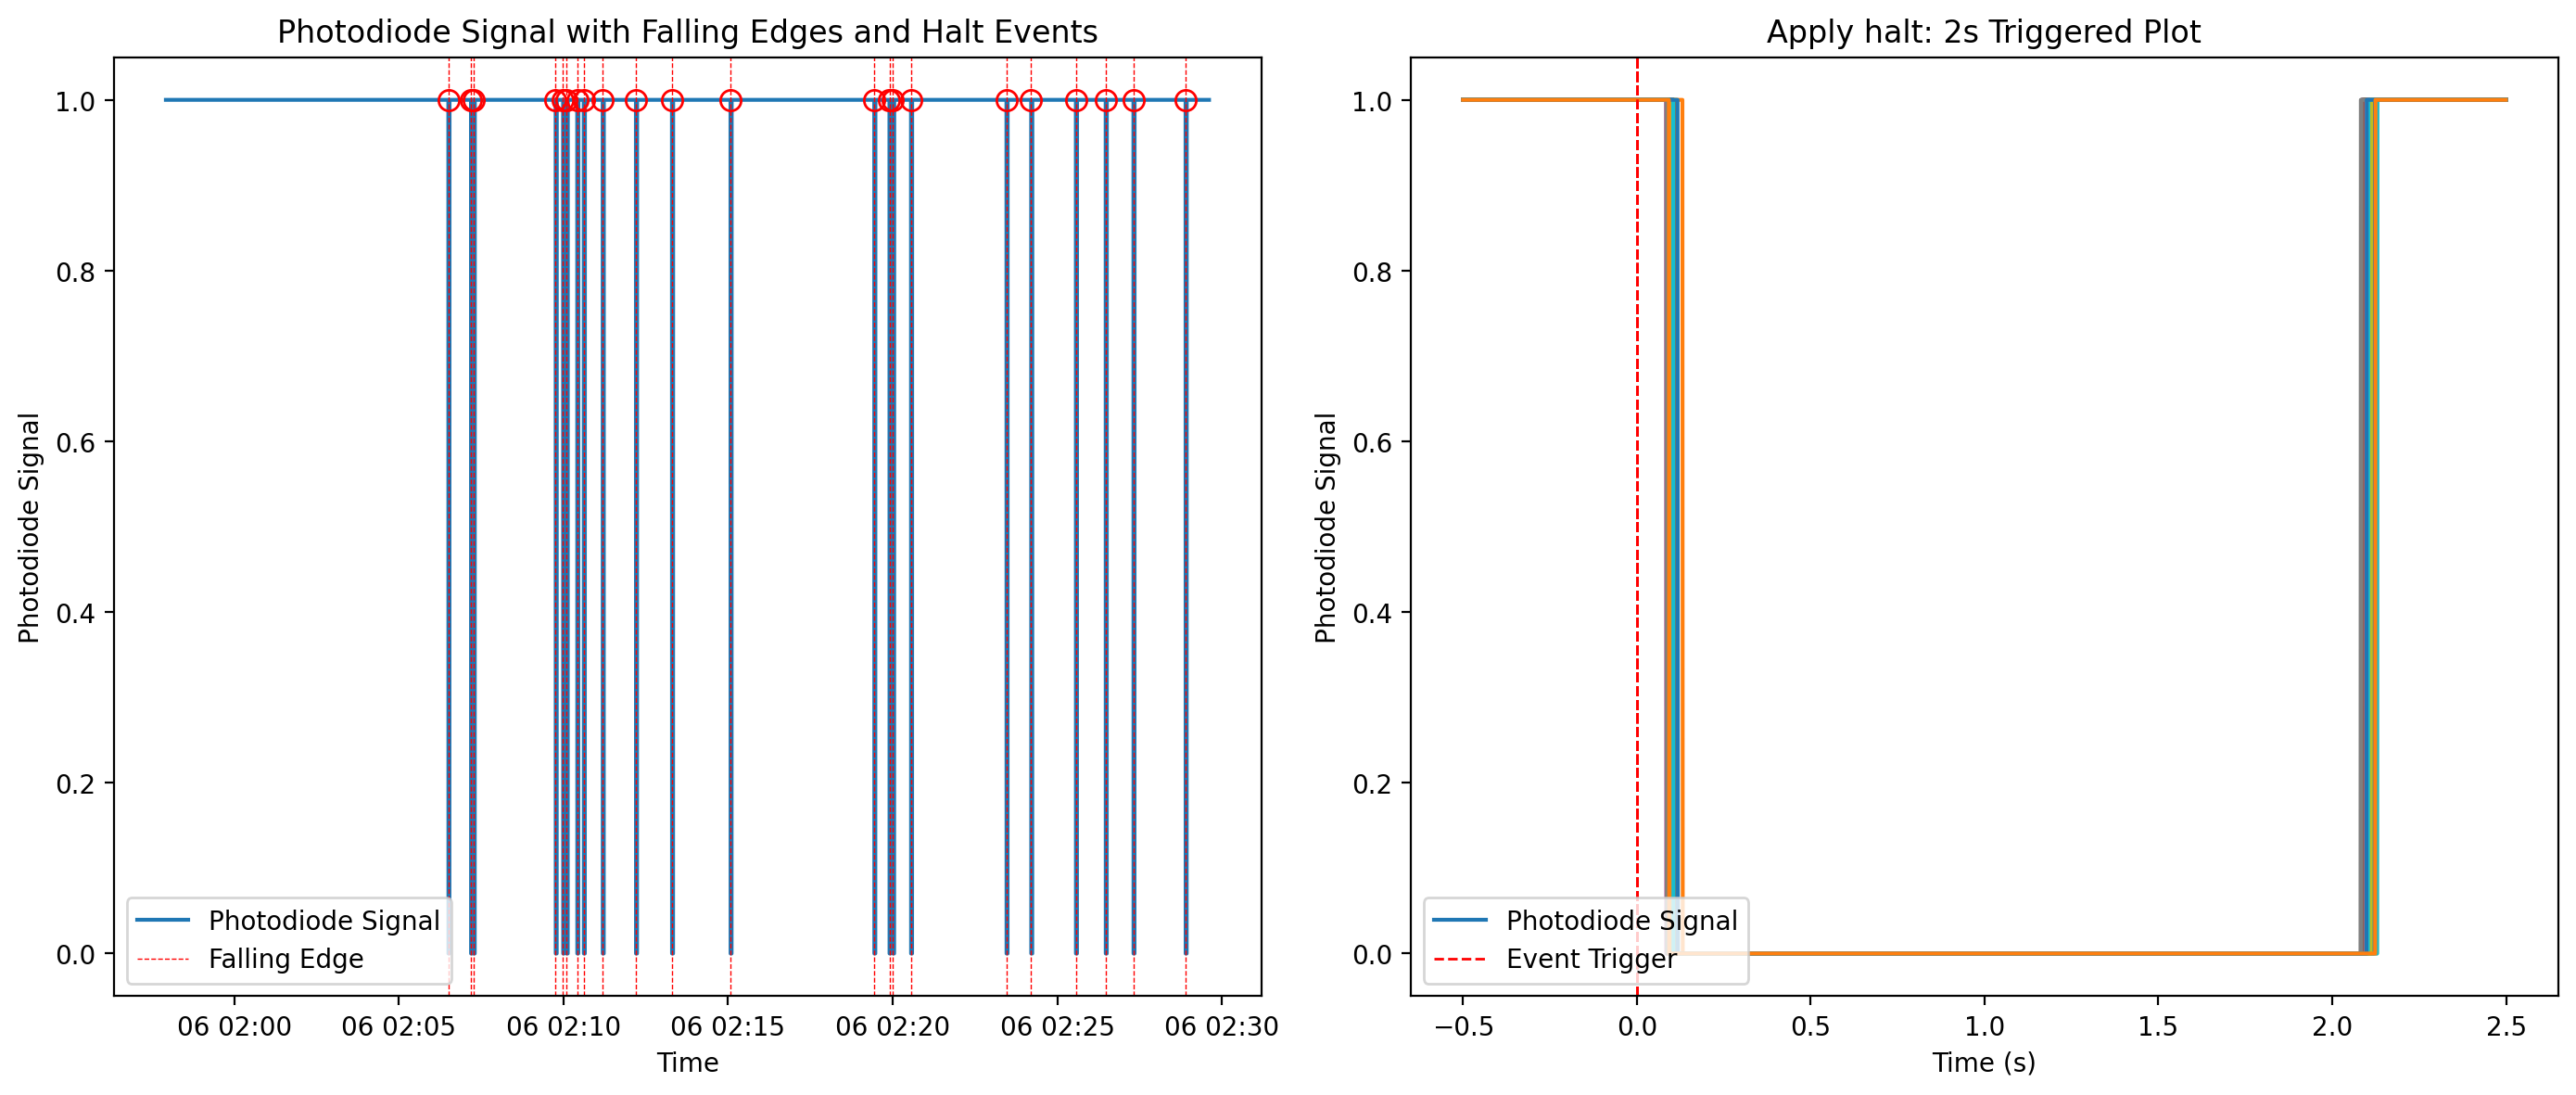

✅ 0 extra falling edges (outside 84.5ms - 132.2ms delay window) were removed before returning.
ℹ️ INFO: skipping figure 1


In [8]:
#---------------------------------------------------
# PLOT FIGURE to ascertain everything is well loaded
#---------------------------------------------------

df_to_analyze = photometry_tracking_encoder_data["Photodiode_int"] #using downsampled values in common time grid 
#df_to_analyze = camera_photodiode_data["Photodiode"] #use async raw values if needed for troubleshooting, but the nearest indices needs to be found , see couple of lines below

if vestibular_mismatch or event_name == "No halt": #determine halt times based on experiment events 
    photodiode_halts = experiment_events[experiment_events["Event"] == event_name].index.tolist()
    nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
    photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices] # as experiment events timestamps are not in the same time grid as downsampled data
    print ("ℹ️ INFO: vestibular MM or 'No halt', no signal in the photodiode, using experiment events for MM times")
else: #determine exact halt times based on photodiode signal
    photodiode_halts, photodiode_delay_min, photodiode_delay_avg, photodiode_delay_max = process.analyze_photodiode(df_to_analyze, experiment_events, event_name, plot = True)
# nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
# photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices]
if plot_fig1:
    process.plot_figure_1(photometry_tracking_encoder_data, session_name, save_path, common_resampled_rate, photodiode_halts, save_figure = True, show_figure = True, downsample_factor=50)
else: 
    print ("ℹ️ INFO: skipping figure 1")
del df_to_analyze
gc.collect()
None

In [75]:
import importlib #for force updating changed packages 
# Force reload the modules
importlib.reload(harp_resources.process)
importlib.reload(harp_resources.utils)
# Reassign after reloading to ensure updated references
process = harp_resources.process
utils = harp_resources.utils